In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,roc_auc_score
import matplotlib.pyplot as plt

In [2]:
class CrossLayer(nn.Module):
    def __init__(self, input_dim):
        super(CrossLayer, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim,1))
        self.bias = nn.Parameter(torch.zeros(1))
        # 初始化权重
        nn.init.xavier_normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x0, x_l):
        """
        x0: 初始输入张量，形状(batch_size, input_dim)
        x_l: 当前层输入张量，形状(batch_size, input_dim)
        返回：x_{l+1} = x0 * x_l^T * W_l + b_l + x_l
        """
        x0 = x0.unsqueeze(2) # (batch_size, input_dim, 1)
        x_l_t = x_l.unsqueeze(1) # (batch_size, 1, input_dim)
        res = torch.bmm(x0, x_l_t) # (batch_size, input_dim, input_dim)
        res = torch.matmul(res, self.weight) # (batch_size, input_dim, 1)
        res = res.squeeze(2) # (batch_size, input_dim)
        res = res + self.bias + x_l
        return res

class CrossNetwork(nn.Module):
    def __init__(self, input_dim, num_layers):
        """
        Args:
            input_dim: 输入特征维度
            num_layers: 堆叠的CrossLayer层数
        """
        super(CrossNetwork, self).__init__()
        self.cross_layers = nn.ModuleList([
            CrossLayer(input_dim) for _ in range(num_layers)
        ]) 

    def forward(self,x):
        """
        Args:
            x: 输入张量，形状(batch_size, input_dim)
        """
        x_l = x
        for layer in self.cross_layers:
            x_l = layer(x,x_l)
        return x_l


class DeepCrossNetwork(nn.Module):
    def __init__(self, num_deep_dim, cat_deep_dims, embedding_dim = 8,cross_num_layers=3, hidden_units = [128, 64],dropout = 0.2):
        """
        Args:
            num_deep_dim: Deep部分的数值型特征数量
            cat_deep_dims: Deep部分的类别特征维度列表
            embedding_dim: 嵌入维度
            cross_num_layers: Cross网络的层数
            hidden_units: 深度网络隐藏层维度列表
        """
        super(DeepCrossNetwork, self).__init__()
        self.num_categorical = len(cat_deep_dims)
        self.num_continuous = num_deep_dim
        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, embedding_dim)
            for dim in cat_deep_dims
        ])
        input_dim = num_deep_dim + len(cat_deep_dims) * embedding_dim
        #Cross网络部分
        self.cross = CrossNetwork(input_dim, cross_num_layers )
        #Deep部分
        dnn = []
        deep_input_dim = input_dim
        for hidden_dim in hidden_units:
            dnn.append(nn.Linear(deep_input_dim, hidden_dim))
            dnn.append(nn.BatchNorm1d(hidden_dim))
            dnn.append(nn.ReLU())
            dnn.append(nn.Dropout(dropout))
            deep_input_dim = hidden_dim
        self.dnn = nn.Sequential(*dnn)
        # 最终输出层
        self.combined_dim = input_dim + hidden_units[-1]
        self.final_layer = nn.Linear(self.combined_dim, 1)

    def forward(self, categorical_input, continuous_input):
        """
        Args:
            categorical_input: 类别型输入，形状(batch_size, num_categorical_features)
            continuous_input: 数值型输入，形状(batch_size, num_continuous_features)
        """
        # 类别特征嵌入处理
        embedded = []
        for i in range(self.num_categorical):
            emd = self.embeddings[i](categorical_input[:, i])
            embedded.append(emd)
        embeded = torch.cat(embedded, dim=1) # 形状(batch_size, num_categorical_features * embedding_dim)
        # 拼接数值型特征和嵌入特征
        x0 = torch.cat([continuous_input, embeded], dim=1)
        # 交叉网络和深度网络
        cross_output = self.cross(x0)
        deep_output = self.dnn(x0)
        # 合并输出
        combined_input = torch.cat([cross_output, deep_output], dim=1)
        #最终输出
        output = self.final_layer(combined_input)
        return torch.sigmoid(output).squeeze(1) # 形状(batch_size,)


In [3]:
# 定义配置
config = {
    "cat_deep_dim": [4, 5, 4],  # 3个类别特征，每个特征的类别数量
    "num_deep_dim": 8,              # 数值型特征的数量
    "embedding_dim": 16,               # 嵌入维度
    "cross_num_layers": 4,            # Cross网络的层数
    "hidden_units": [128, 64,32],        # 深度网络隐藏层维度列表
    "dropout": 0.3,                   # Dropout率
    "batch_size": 32,                 # 批量大小
    "num_epochs": 30,                 # 训练轮数
    "num_samples": 1000,              # 数据集样本数量
    "learning_rate": 0.005            # 学习率
}

In [4]:
class Dataset(Dataset):
    def __init__(self, num_samples, config):
        X, y = make_classification(
            n_samples=num_samples,
            n_features=config["num_deep_dim"],
            n_informative=config["num_deep_dim"] - 2,
            n_redundant=2,
            n_classes=2,
        )
        # 随机选取部分数值型特征
        self.num_data = torch.tensor(X, dtype=torch.float32)
        # 随机生成分类特征
        self.deep_data = torch.cat([
            torch.randint(0, dim, (num_samples, 1)) for dim in config["cat_deep_dim"]
        ], dim=1)

        self.labels = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.num_data[idx], self.deep_data[idx], self.labels[idx]

In [5]:
# 定义训练函数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for continuous, categorical, labels in train_loader:
        continuous, categorical, labels = continuous.to(device), categorical.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(categorical, continuous)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * continuous.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# 定义验证函数
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for continuous, categorical, labels in val_loader:
            continuous, categorical, labels = continuous.to(device), categorical.to(device), labels.to(device)
            outputs = model(categorical, continuous)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * continuous.size(0)
    epoch_loss = running_loss / len(val_loader.dataset)
    return epoch_loss

In [6]:
# 设置随机种子以确保结果可复现
torch.manual_seed(42)
np.random.seed(42)
# 生成数据
train_dataset = Dataset(config["num_samples"], config)
# 划分训练集和验证集
train_size = int(0.7 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)
# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepCrossNetwork(
    num_deep_dim=config["num_deep_dim"],
    cat_deep_dims=config["cat_deep_dim"],
    embedding_dim=config["embedding_dim"],
    cross_num_layers = config["cross_num_layers"],
    hidden_units=config["hidden_units"],
    dropout = config["dropout"]
    
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"],weight_decay = 1e-3 )
# 训练模型
train_losses = []
val_losses = []
pbar = tqdm(range(config["num_epochs"]))
for epoch in pbar:
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    pbar.set_postfix({
        'Train Loss': f'{train_loss:.4f}', 
        'Val Loss': f'{val_loss:.4f}'
    })

100%|██████████| 30/30 [00:04<00:00,  6.07it/s, Train Loss=0.1775, Val Loss=0.4856]


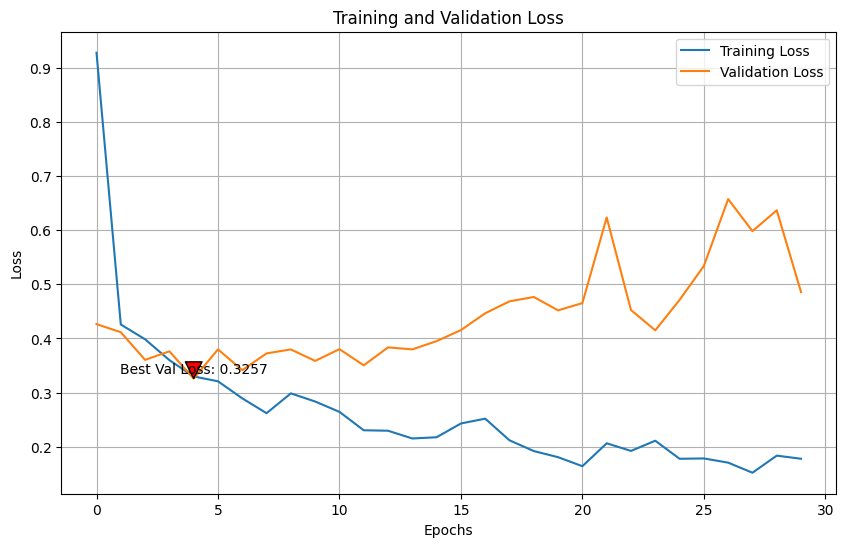

Training complete. Best validation loss: 0.3257 at epoch 5


In [7]:
# 绘制训练及评估loss曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 标记最佳验证损失点
best_epoch = np.argmin(val_losses)
plt.annotate(f'Best Val Loss: {val_losses[best_epoch]:.4f}',
             xy=(best_epoch, val_losses[best_epoch]),
             xytext=(best_epoch, val_losses[best_epoch] + 0.01),
             arrowprops=dict(facecolor='red', shrink=0.05),
             horizontalalignment='center')

plt.savefig('loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training complete. Best validation loss: {val_losses[best_epoch]:.4f} at epoch {best_epoch+1}")

相关论文 Deep & Cross Network for Ad Click Predictions https://arxiv.org/abs/1708.05123 